In [4]:
import pandas as pd
import numpy as np

path=r"D:\Data_Science\Project\Tele-Customer-Chum\Telco-Customer-Churn.csv"
df=pd.read_csv(path)

df.shape,df.dtypes.head()

df.head(3)

df.isna().sum().sort_values(ascending=False).head(10)


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

In [10]:
df=df.drop(columns=["customerID"],errors="ignore")#identifier droped

obj_cols=df.select_dtypes(include="object").columns #Strip whitespace for all the features/columns
for c in obj_cols:
    df[c]=df[c].astype(str).str.strip()#made into string 

df["TotalCharges"]= pd.to_numeric(df['TotalCharges'],errors="coerce")
rows_before = len(df)
df = df.dropna(subset=["TotalCharges"]) 
print("Dropped due to TotalCharges NAN:",rows_before-len(df))

df.isna().sum().sort_values(ascending=False).head(10)

Dropped due to TotalCharges NAN: 11


gender              0
SeniorCitizen       0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

In [ ]:
# Verify and standardize a few binary columns
yes_no_cols = [
    "Churn","Partner","Dependents","PhoneService","PaperlessBilling",
    "MultipleLines","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies"
]
for c in yes_no_cols:
    if c in df.columns:
        df[c] = df[c].replace({"Yes":"Yes","No":"No"})

print("Churn unique:", df["Churn"].unique())
print("gender unique:", df["gender"].unique())
print("Contract unique:", df["Contract"].unique())


Churn unique: ['No' 'Yes']
gender unique: ['Female' 'Male']
Contract unique: ['Month-to-month' 'One year' 'Two year']


In [12]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes":1, "No":0})
print(X.shape, y.shape, "Churn rate:", round(y.mean(), 3))


(7032, 19) (7032,) Churn rate: 0.266


#Training

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# Simple one-hot encoder (drop='first' to avoid dummy trap as per notes)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# Baseline Logistic Regression pipeline (notes default, no heavy tuning)
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)[:,1]

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "precision": precision_score(y_test, pred),
    "recall": recall_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba)
}
metrics

def to_pct(d, ndigits=2):
    return {k: round(v*100, ndigits) for k, v in d.items()}

pct_metrics = to_pct(metrics, 2)
pct_metrics


{'accuracy': 80.03,
 'precision': 63.96,
 'recall': 56.95,
 'f1': 60.25,
 'roc_auc': 83.67}

#Confusion matrix(How many predictions were correct)

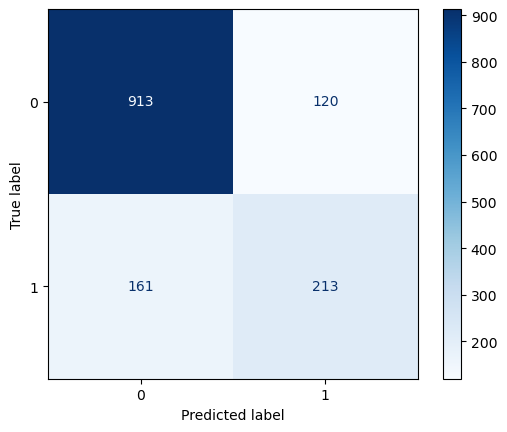

array([[913, 120],
       [161, 213]], dtype=int64)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

cm


Compare Logistic Regression, Naive Bayes, Decision Tree, Random Forest, KNN, and SVM on the same one‑hot encoded data (scale only KNN/SVM) and report Accuracy, Precision, Recall, F1, and ROC‑AUC as percentages to pick the best simple classifier for churn.

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_model(pipe):
    pipe.fit(X_train, y_train)
    p = pipe.predict(X_test)
    # Get a score for ROC-AUC
    if hasattr(pipe, "predict_proba"):
        pr = pipe.predict_proba(X_test)[:,1]
    else:
        pr = pipe.decision_function(X_test)
    out = {
        "accuracy": accuracy_score(y_test, p),
        "precision": precision_score(y_test, p),
        "recall": recall_score(y_test, p),
        "f1": f1_score(y_test, p),
        "roc_auc": roc_auc_score(y_test, pr)
    }
    # convert to percentages
    return {k: round(v*100, 2) for k, v in out.items()}

# Reuse the same preprocess (one-hot + passthrough numerics)
# 1) Logistic Regression (already trained) — re-evaluate for consistent formatting
logreg_pct = {k: round(v*100, 2) for k, v in metrics.items()}

# 2) Naive Bayes
nb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", GaussianNB())
])
nb_pct = eval_model(nb)

# 3) Decision Tree
dt = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])
dt_pct = eval_model(dt)

# 4) Random Forest
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])
rf_pct = eval_model(rf)

# 5) KNN (scale needed for distance-based model)
knn = Pipeline(steps=[
    ("prep", preprocess),
    ("scale", StandardScaler(with_mean=False)),  # safe with sparse one-hot
    ("clf", KNeighborsClassifier(n_neighbors=5))
])
knn_pct = eval_model(knn)

# 6) SVM (scale + probability for ROC-AUC)
svm = Pipeline(steps=[
    ("prep", preprocess),
    ("scale", StandardScaler(with_mean=False)),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])
svm_pct = eval_model(svm)

results_pct = {
    "LogReg": logreg_pct,
    "NB": nb_pct,
    "DT": dt_pct,
    "RF": rf_pct,
    "KNN": knn_pct,
    "SVM": svm_pct
}
results_pct


{'LogReg': {'accuracy': 80.03,
  'precision': 63.96,
  'recall': 56.95,
  'f1': 60.25,
  'roc_auc': 83.67},
 'NB': {'accuracy': 64.39,
  'precision': 41.79,
  'recall': 86.36,
  'f1': 56.32,
  'roc_auc': 81.05},
 'DT': {'accuracy': 71.14,
  'precision': 45.88,
  'recall': 47.59,
  'f1': 46.72,
  'roc_auc': 63.63},
 'RF': {'accuracy': 78.82,
  'precision': 62.75,
  'recall': 50.0,
  'f1': 55.65,
  'roc_auc': 81.89},
 'KNN': {'accuracy': 75.48,
  'precision': 53.87,
  'recall': 54.01,
  'f1': 53.94,
  'roc_auc': 76.75},
 'SVM': {'accuracy': 78.89,
  'precision': 63.23,
  'recall': 49.2,
  'f1': 55.34,
  'roc_auc': 79.45}}

In [17]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# Pipeline: preprocess -> PCA -> Logistic Regression
pca_logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", PCA(n_components=0.95, svd_solver="full")),  # keep 95% variance
    ("clf", LogisticRegression(max_iter=1000))
])

pca_logreg.fit(X_train, y_train)
p_pred = pca_logreg.predict(X_test)
p_proba = pca_logreg.predict_proba(X_test)[:,1]

p_metrics = {
    "accuracy": round(accuracy_score(y_test, p_pred)*100, 2),
    "roc_auc": round(roc_auc_score(y_test, p_proba)*100, 2)
}
n_comp = pca_logreg.named_steps["pca"].n_components_
{"PCA_components": int(n_comp), "LogReg_noPCA": {k: round(v*100,2) for k,v in metrics.items()}, "LogReg_withPCA": p_metrics}


{'PCA_components': 1,
 'LogReg_noPCA': {'accuracy': 80.03,
  'precision': 63.96,
  'recall': 56.95,
  'f1': 60.25,
  'roc_auc': 83.67},
 'LogReg_withPCA': {'accuracy': 73.42, 'roc_auc': 65.49}}

# Tele Customer Churn — Summary

### Overview
- Goal: Predict churn (Yes/No) with a simple, notes‑aligned pipeline; final model is non‑PCA Logistic Regression due to stronger Accuracy and ROC‑AUC. [attached_file:8]

### Data and cleaning
- Data: Telco Customer Churn CSV; target Churn; 7,032 rows used after cleaning. [attached_file:8]
- Cleaning: dropped customerID, stripped whitespace in strings, converted TotalCharges to numeric, dropped rows where it became NaN. [attached_file:6]

### Preprocessing
- One‑hot encoded categorical features with drop‑first; numeric features passed through; avoided dummy trap. [attached_file:6]
- Train/test split with stratify on Churn to preserve class balance. [attached_file:8]

### Baseline model
- Pipeline: preprocess → Logistic Regression (simple defaults). [attached_file:8]
- Test metrics (%): Accuracy 80.03, Precision 63.96, Recall 56.95, F1 60.25, ROC‑AUC 83.67. [attached_file:8]

### Confusion matrix
- Used to visualize TP, TN, FP, FN; complements percentage metrics for final evaluation. [attached_file:8]

### Model comparison
- Compared Naive Bayes, Decision Tree, Random Forest, KNN, and SVM with the same preprocessing; scaled only KNN/SVM. [attached_file:0][attached_file:1][attached_file:6]
- Selection note: prefer by ROC‑AUC and confirm Recall; if similar, keep Logistic Regression for interpretability. [attached_file:8]

### PCA check
- PCA (95% variance → 1 component) reduced performance (Acc 73.42, ROC‑AUC 65.49); not adopted. [attached_file:3]

### Conclusion
- Final choice: non‑PCA Logistic Regression with the reported metrics; include confusion matrix plot and optionally note the simple model comparison for due diligence. [attached_file:8][attached_file:0]
